# Árbol de decisión para encuesta Reddit Chile

## Conexión a fuente de datos

In [4]:
import numpy as np
import pandas as pd

In [6]:
df = pd.read_pickle("data/df_encuesta.pkl")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1170 entries, 0 to 1181
Data columns (total 47 columns):
 #   Column                     Non-Null Count  Dtype
---  ------                     --------------  -----
 0   edad                       1170 non-null   int32
 1   religion                   1170 non-null   int8 
 2   sexo_Hombre                1170 non-null   uint8
 3   sexo_Mujer                 1170 non-null   uint8
 4   orientacion_Bisexual       1170 non-null   uint8
 5   orientacion_Heterosexual   1170 non-null   uint8
 6   orientacion_Homosexual     1170 non-null   uint8
 7   ocupacion_Estudio          1170 non-null   uint8
 8   ocupacion_Ninguna          1170 non-null   uint8
 9   ocupacion_Trabajo          1170 non-null   uint8
 10  ocupacion_Trabajo;Estudio  1170 non-null   uint8
 11  region_I                   1170 non-null   uint8
 12  region_II                  1170 non-null   uint8
 13  region_III                 1170 non-null   uint8
 14  region_IV               

# Selección de variables predictoras y de respuesta.

In [8]:
X = df.loc[:, ~df.columns.isin(['politica_izquierda'])]
y = df['politica_izquierda']

# Generación data de entrenamiento y testeo más balanceo

In [9]:
#creemos ahora muestras de entrenamiento y prueba seleccionadas aleatoriamente:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                    random_state = 42)

In [10]:
# balaceo con sobremuestro
y_train_Q = y_train[y_train == 1]
y_train_NQ = y_train[y_train == 0]
y_train_Q = y_train_Q.sample(len(y_train_NQ), replace = True, random_state = 42)
y_train = pd.concat([y_train_Q, y_train_NQ], axis=0)
y_train.value_counts()
X_train = X_train.loc[y_train.index,:]

del [y_train_Q, y_train_NQ]

# Cross-Validation y Grid-Search

In [12]:
import multiprocessing

cores = multiprocessing.cpu_count()
cores

12

## Solo Cross-Validation

In [13]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

# modelo logístico base
tree_cv = DecisionTreeClassifier(random_state = 42)
tree_cv = tree_cv.fit(X, y)
# Validación cruzada
cv = cross_validate(tree_cv,
                    X,
                    y,
                    cv = 5,
                    n_jobs = cores,
                    return_train_score = True)
cv

{'fit_time': array([0.00698137, 0.00797796, 0.00897622, 0.00797915, 0.0083909 ]),
 'score_time': array([0.00299144, 0.00299215, 0.00440407, 0.00199437, 0.00199413]),
 'test_score': array([0.52991453, 0.54273504, 0.61965812, 0.54700855, 0.57264957]),
 'train_score': array([0.99465812, 0.99465812, 0.99465812, 0.9957265 , 0.99465812])}

## Grid-Search

In [22]:
from sklearn.model_selection import GridSearchCV

param_grid = {'max_features': ['sqrt', 'log2', None],
              'ccp_alpha': [0.1, .01, .001],
              'max_depth' : [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
              'criterion' :['gini', 'entropy'],
              'min_samples_split' : [0.1, 0.2, 0.3, 0.4, 0.5],
              'min_samples_leaf' : [0.1, 0.2, 0.3, 0.4, 0.5]
             }
tree_clas = DecisionTreeClassifier(random_state = 42)
grid_search = GridSearchCV(estimator = tree_clas, 
                           param_grid = param_grid,
                           cv = 5, 
                           verbose = True, 
                           n_jobs = cores)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4500 candidates, totalling 22500 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42), n_jobs=12,
             param_grid={'ccp_alpha': [0.1, 0.01, 0.001],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10, None],
                         'max_features': ['sqrt', 'log2', None],
                         'min_samples_leaf': [0.1, 0.2, 0.3, 0.4, 0.5],
                         'min_samples_split': [0.1, 0.2, 0.3, 0.4, 0.5]},
             verbose=True)

In [23]:
modelo = grid_search.best_estimator_
modelo

DecisionTreeClassifier(ccp_alpha=0.001, max_depth=4, min_samples_leaf=0.1,
                       min_samples_split=0.1, random_state=42)

# Ajuste y Gráfico árbol de decisión

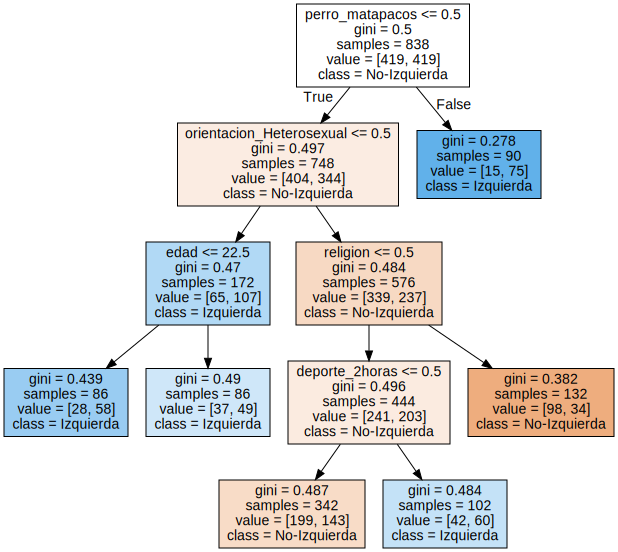

In [24]:
from sklearn import tree
from graphviz import Source
from IPython.display import SVG

# Separamos en X e Y:
modelo.fit(X_train, y_train)

# Graficamos árbol:
tree.export_graphviz(modelo, out_file='tree_balanced.dot')
graph = Source(tree.export_graphviz(modelo, out_file=None, feature_names = X_train.columns, 
                                    class_names=['No-Izquierda', 'Izquierda'], filled = True))
display(SVG(graph.pipe(format='svg')))

# Resultados modelo

## Matrices de confusión

In [25]:
y_pred_train = modelo.predict(X_train)
y_pred_train = pd.DataFrame(y_pred_train, columns=["Y_predicha"],index = y_train.index)

from sklearn.metrics import classification_report
print("Resultado en Muestra de Entrenamiento:")

print(classification_report(y_train, y_pred_train))

Resultado en Muestra de Entrenamiento:
              precision    recall  f1-score   support

           0       0.63      0.71      0.67       419
           1       0.66      0.58      0.62       419

    accuracy                           0.64       838
   macro avg       0.65      0.64      0.64       838
weighted avg       0.65      0.64      0.64       838



In [26]:
y_pred_test = modelo.predict(X_test)
y_pred_test = pd.DataFrame(y_pred_test, columns=["Y_predicha"],index = y_test.index)

print("Resultado en Muestra de Prueba:")

print(classification_report(y_test, y_pred_test))

Resultado en Muestra de Prueba:
              precision    recall  f1-score   support

           0       0.58      0.71      0.64       117
           1       0.63      0.50      0.56       117

    accuracy                           0.60       234
   macro avg       0.61      0.60      0.60       234
weighted avg       0.61      0.60      0.60       234



**Precision**: Cada vez que el modelo determina que un usuario de Reddit es de izquierda, acertará un 63% de las veces.  
**Recall**: El modelo es capaz de identificar al 50% de las personas que son efectivamente de izquierda.  
**Accuracy**: El modelo acierta un 60% de las veces.

## Curva ROC & AUC

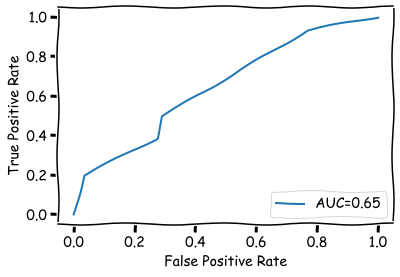

In [27]:
from sklearn import metrics
import matplotlib.pyplot as plt

y_prob_test = modelo.predict_proba(X_test)[:,1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_prob_test)
auc = round(metrics.roc_auc_score(y_test, y_prob_test),2)

with plt.xkcd():
    plt.plot(fpr, tpr, label="AUC="+str(auc))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

## Variance Importance Factor

In [28]:
vil = pd.DataFrame(list(zip(X.columns,modelo.feature_importances_)),
                   columns=['feature','mean_entropy_decrease']
                  ).sort_values(by='mean_entropy_decrease', ascending=False)
vil.head()

,feature,mean_entropy_decrease
43,perro_matapacos,0.469166
5,orientacion_Heterosexual,0.246090
1,religion,0.169815
35,deporte_2horas,0.095207
0,edad,0.019722
